In [1]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [2]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [3]:
pwd

'C:\\Users\\이동환\\Desktop'

In [4]:
# 네이버에서 검색어 입력받아 검색 한 후 블로그 메뉴를 선택하고
# 오른쪽에 있는 검색옵션 버튼을 눌러서
# 정렬 방식과 기간을 입력하기

#Step 0. 필요한 모듈과 라이브러리를 로딩하고 검색어를 입력 받습니다.
import sys
import os
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from selenium import webdriver
import time
import tqdm
from tqdm.notebook import tqdm

In [1]:
query_txt = input('1.크롤링할 키워드는 무엇입니까?: ')
# query_txt2 = input('2.제외할 첫번째 키워드를 입력하세요: ')
# query_txt3 = input('3.제외할 두번째 키워드를 입력하세요: '|)

start_date = input('4.조회를 시작할 날짜를 입력하세요(예:2017-01-01) :')
end_date = input('5.조회를 종료할 날짜를 입력하세요(예:2017-12-31): ')

1.크롤링할 키워드는 무엇입니까?: 이재용
4.조회를 시작할 날짜를 입력하세요(예:2017-01-01) :20200608
5.조회를 종료할 날짜를 입력하세요(예:2017-12-31): 20200614


In [2]:
query_txt="이재용"
start_date="20200608"
end_date="20200614"

In [5]:
#Step 1. 크롬 웹브라우저 실행
path = "chromedriver.exe"

driver = webdriver.Chrome(path)
# 사이트 주소는 네이버
driver.get('http://www.naver.com')
time.sleep(2)

#Step 2. 네이버 검색창에 "검색어" 검색
element = driver.find_element_by_id("query")
element.send_keys(query_txt)  # query_txt는 위에서 입력한 '이재용'
element.submit()

#Step 3. "블로그" 카테고리 선택
driver.find_element_by_link_text("블로그").click( )    # .click() 괄호 안을 눌러라는 뜻

#Step 4. 오른쪽의 검색 옵션 버튼 클릭
driver.find_element_by_id("_search_option_btn").click( )

#Step 5. 정렬 : "관련도순" 
# 개발자 도구에서 정렬 버튼의 id 가 보이지 않습니다.
# 이럴 경우 쉽게 사용할 수 있는 방법이 바로 xpath 를 이용하는 방법입니다.
# xpath는 개발자 도구에서 해당 메뉴 부분을 마우스 오른쪽 버튼을 누르고 
# copy -> copy xpath 를 선택하면 됩니다
# xpath 에 대한 자세한 내용은 이번 장의 뒷 부분을 참고하세요.

driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/a""").click( )  # 정렬 버튼의 xpath 클릭
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/div/ul/li[1]/a""").click( ) # 관련도순 xpath

#Step 6. 날짜 입력
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[2]/a""").click()
time.sleep(2)

# 이 부분이 아주 중요합니다.
# 날짜 부분에 날짜를 입력할 때 입력 속도가 너무 빠를 경우 날짜가 입력이 되다가 
# 오타가 나오는 경우가 많습니다.
# 그래서 날짜를 입력할 때 for 반복문을 사용해서 1 글자씩 입력하도록 코딩했습니다.

# 시작 날짜 입력하기
s_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""")     
driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""").click()
s_date.clear( )  # 날짜 입력 부분에 기존에 입력되어 있던 날짜를 제거합니다. 
time.sleep(1)
# 아래 코드가 날짜를 for 반복문으로 1 글자씩 입력하는 부분입니다.
for c in start_date:
    s_date.send_keys(c)
    time.sleep(0.1)
    
# 종료 날짜 입력하기
e_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""")
driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""").click()
e_date.clear()
time.sleep(1)

for c in end_date:
    e_date.send_keys(c)
    time.sleep(0.1)
    
# Step7. 날짜 입력 "적용하기" 버튼을 클릭 합니다.  
driver.find_element_by_class_name("tx").click()
time.sleep(3)

# # Step 8. 상세 검색버튼을 클릭 후 제외할 단어들을 설정합니다.
# ele2 = driver.find_element_by_id("inpop3")
# ele2.send_keys(query_txt2)
# ele2.send_keys(',')
# ele2.send_keys(query_txt3)
# driver.find_element_by_css_selector(".btn_ft.ty_green._search").click( )

## url 크롤링 시작

In [6]:
url_list = []
title_list = []

# ★몇개의 페이지를 크롤링할지 선택
total_page = 10
for i in tqdm(range(0, total_page)):  # 페이지 번호
    i = i*10 + 1
    url = "https://search.naver.com/search.naver\
?date_from={0}&date_option=8&date_to={1}\
&dup_remove=1&nso=p%3Afrom{2}to{3}post_blogurl=\
&post_blogurl_without=&query={4}&sm=tab_pge&srchby=all&st=sim&where=post&start={5}".format(start_date,end_date,start_date,end_date,query_txt, i)
    driver.get(url)
    time.sleep(0.5)
    
    # URL 크롤링 시작
    titles = "a.sh_blog_title._sp_each_url._sp_each_title"
    article_raw = driver.find_elements_by_css_selector(titles)
#     article_raw

    # url 크롤링 시작    
    for article in article_raw:
        url = article.get_attribute('href')   
        url_list.append(url)
    
    # 제목 크롤링 시작    
    for article in article_raw:
        title = article.get_attribute('title')   
        title_list.append(title)
    
        print(title)
    
print('url갯수: ', len(url_list))
print('url갯수: ', len(title_list))

df = pd.DataFrame({'url':url_list, 'title':title_list})

# 저장하기
df.to_excel("blog_url.xlsx")

[사설]이재용 영장 기각, 검찰은 남은 수사 차질 없이 진행해야
이재용 부회장 영장실질심사
이재용 영장 기각... 법원 "구속 필요성 소명 부족"
문재인 은하수다 3 - 박근혜의 이재용, 문재인의 이재용은 무엇이 다른가?
삼성바이오로직스 이재용 부회장 경영권 승계 꼬리표 떼고 날아 올랐다
이재용 구속영장 청구, 호텔신라가 왜 뜰까?
이재용 삼성전자 부회장 구속 영장 청구 이유 정리
이재용 구속, 한국 대통령에게는 사면권이 있다
이재용 부회장 구속영장 기각…구속 여부보다 ‘새 옷’을 입을 때다
삼성 이재용의 구속기각을 보며
이재용 부회장, 3년 7개월 째 수사 받으며 세 번째 영장심사…항소심 집행유예 석방 854일 만
오늘 새벽 삼성 이재용 부회장의 구속영장이 기각되었습니다
[속보] 삼성그룹 이재용 경영권 불법승계 의혹 구속영장심사, 국민 60%선처 의견, 2년4개월만에 구속위기
이재용 영장 기각... 법원 "구속 필요성 소명 부족"
4.15 부정선거와 삼성 이재용의 차기 대권 도전 선언
<삼성 이재용 부회장 영장 기각> 삼성 최악 모면
법원 9일 이재용 삼성전자 부회장 구속영장 기각 사법개혁이 필요한 이유
초호화 변호인단이 이재용 구속 막았다?
[외전 14] 삼성의 이재용 부회장의 판결을 바라보는 국민들의 시선들
경제신문스크랩 - 이재용 불구속 … 한숨 돌린 삼성
‘남북채널 차단’ ‘이재용 영장기각’에 대한 보혁의 해설 차이...한국 기사는 객관, 사설은 진보
이재용 영장실질심사 종료 구속여부 8일 9일 사이 결정될 듯
이재용과 수사심의위원회 (최창호 변호사)
이재용 구속, 삼성전자 주식은??팔어?
[중국어 공부/기사해석] 이재용 영장심사
이재용 구속영장 기각하는 삼성재벌공화국 법원 판사
오늘 삼성 이재용 부회장의 재구속 여부가 결정됩니다
[삼성전자 / 이재용 호재] 이재용 부회장 영장기각 후 경영방향
삼성 이재용부회장의 구속영장기각, 왜?
이재용 구속 영장 기각 선처 vs 법대로
이재용
삼성 이재용 부회장 재구속위기 영장발부 심사중-재벌과 기업총수들 이제 그

# 글 크롤링하기

In [7]:
import sys
import os
import pandas as pd
import numpy as np

In [8]:
# "url_list.csv" 불러오기
url_load = pd.read_excel("blog_url.xlsx")        # 기본 모델

num_list = len(url_load)

print(num_list)
url_load

100


,url,title
0,https://opinionx.khan.kr/21765,"[사설]이재용 영장 기각, 검찰은 남은 수사 차질 없이 진행해야"
1,https://blog.naver.com/amabella?Redirect=Log&l...,이재용 부회장 영장실질심사
2,https://pinepark.blog.me/221994594037,"이재용 영장 기각... 법원 ""구속 필요성 소명 부족"""
3,https://blog.naver.com/wavata?Redirect=Log&log...,"문재인 은하수다 3 - 박근혜의 이재용, 문재인의 이재용은 무엇이 다른가?"
4,https://blog.naver.com/johnkth?Redirect=Log&lo...,삼성바이오로직스 이재용 부회장 경영권 승계 꼬리표 떼고 날아 올랐다
5,https://blog.naver.com/joooople?Redirect=Log&l...,"이재용 구속영장 청구, 호텔신라가 왜 뜰까?"
6,https://blog.naver.com/seokks0919?Redirect=Log...,이재용 삼성전자 부회장 구속 영장 청구 이유 정리
7,https://blog.naver.com/godjinho?Redirect=Log&l...,"이재용 구속, 한국 대통령에게는 사면권이 있다"
8,https://fishes1272.blog.me/221994786832,이재용 부회장 구속영장 기각…구속 여부보다 ‘새 옷’을 입을 때다
9,https://blog.naver.com/entopia21?Redirect=Log&...,삼성 이재용의 구속기각을 보며


In [11]:
dict = {}  # 전체 크롤링 데이터를 담을 그릇

# ★수집할 글 갯수
number = 100
for i in tqdm(range(0, number)): 
    # 글 띄우기
    url = url_load['url'][i]
    driver = webdriver.Chrome("chromedriver.exe")
    driver.get(url)   # 글 띄우기
    
    # 크롤링
    
    try : 
        # iframe 접근
        driver.switch_to_frame('mainFrame')

        target_info = {}

        # 제목 크롤링 시작
        overlays = ".se-fs-.se-ff-"                                 
        tit = driver.find_element_by_css_selector(overlays)         # title
        title = tit.text
        title

        # 글쓴이 크롤링 시작
        overlays = ".nick"                                 
        nick = driver.find_element_by_css_selector(overlays)         # nick
        nickname = nick.text

        # 날짜 크롤링
        overlays = ".se_publishDate.pcol2"                                 
        date = driver.find_element_by_css_selector(overlays)         # date
        datetime = date.text

        # 내용 크롤링
        overlays = ".se-component.se-text.se-l-default"                                 
        contents = driver.find_elements_by_css_selector(overlays)         # date

        content_list = []
        for content in contents:
            content_list.append(content.text)

        content_str = ' '.join(content_list)

        # 글 하나는 target_info라는 딕셔너리에 담기게 되고,
        target_info['title'] = title
        target_info['nickname'] = nickname
        target_info['datetime'] = datetime
        target_info['content'] = content_str

        # 각각의 글은 dict라는 딕셔너리에 담기게 됩니다.
        dict[i] = target_info
        time.sleep(1)
        
        print(i, title)

        # 글 하나 크롤링 후 크롬 창 닫기
        driver.close()       
    
    # 에러나면 현재 크롬창 닫고 다음 글(i+1)로 이동
    except:
        driver.close()
        time.sleep(1)
        continue
    
    # 중간,중간에 파일로 저장하기
    if i == 30 or 50 or 80:
        # 판다스로 만들기
        import pandas as pd
        result_df = pd.DataFrame.from_dict(dict, 'index')

        # 저장하기
        result_df.to_excel("blog_content_이재용심사후.xlsx")
        time.sleep(3)
    
print('수집한 글 갯수: ', len(dict))
print(dict)    
    
# 판다스로 만들기
import pandas as pd
result_df = pd.DataFrame.from_dict(dict, 'index')

# 저장하기
result_df.to_excel("blog_content_이재용심사후.xlsx")

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: use driver.switch_to.frame instead
  from ipykernel import kernelapp as app


2 이재용 영장 기각... 법원 "구속 필요성 소명 부족"
3 문재인 은하수다 3 - 박근혜의 이재용, 문재인의 이재용은 무엇이 다른가?
4 
5 이재용 구속영장 청구 관련주는?
6 이재용 삼성전자 부회장 구속 영장 청구 이유 정리
7 이재용 구속, 한국 대통령에게는 사면권이 있다
8 오후 4시 경 서관 뒤쪽 주차장 모습이다. 이재용 부회장의 영장실질심사가 저녁 7시 경에 끝났으니 이 사진 찍을 무렵 법정에선 한창 검찰과 피의자측이 열을 올리고 있을 때였을 것이다. 
9 © Mediamodifier, 출처 Pixabay
12 안녕 하세요 요즘 몸이 안좋아서
15 https://youtu.be/VMSvY8G6xQM
16 
17 초호화 변호인단이 이재용 구속 막았다?
19 법원 "증거 확보됐지만 구속 필요성은 없어"
20 <0610 중도정론 표방 한국 기사 비교>
22 이재용과 수사심의위원회 (최창호 변호사) 
23 이재용 구속, 삼성전자 주식은??팔어?
24 [중국어 공부/기사해석]
26 
27 삼성전자 이재용 부회장 영장기각
34 [서울포스트진단] 검찰의 삼성,삼바분식회계수사에서 이재용이 수사심의위원회 소집신청은 문재인과 손잡고 윤석열사단 압박 노림수


C:\Program Files\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:832: UserWarning: Ignoring URL 'http://www.seoulpost.co.kr/news/41802%20%20%20

관련기사
%20%20

%5b서울포스트논단%5d%20똘끼녀%20추미애를%20앞세운%20광끼남%20문재인%20작전%20성공은%20돈에%20환장한%20정권과%20삼성유착%20감추기%20위해%20검찰개혁%20내세운%20광란의%20칼춤이자%20검찰%20대학살극%20-%20%5b황장수의%20뉴스브리핑-정치분석%5d참고:%20「문」・「추」,%20삼성출신을%20검찰국장%20불법으로%20앉히려다%20망신!%20이념도%20아닌%20「재벌수사%20막으려」%20일어난%20공수처%20독재%20%20양기용%20기자%20(2020.01.09)
%20%20

%5b진단%5d%20일본은%20노벨상%2026명(한국%201)..%20문재인이%20박박%20긁어%20촉발된%20아베%20의%20무역전쟁%20선전포고에,%20인조가%20청태종한테%20남한산성,삼전도에서%20머리%20조아리듯,%20아베앞에%20이마%20아홉번%20찍고%20용서%20빌어야!%20%20양기용%20기자%20(2019.07.06)
%20%20

%5b서울포스트%20최종분석%5d%20일본은%20배울%20점%20많은%20무서운%20선진국..%20지금껏%20감정적으로%20친일부역자청산%20내세워%20무시하고%20폄하한%20문재인과%20한국국민은%20일본%20종신노예된다%20%20양기용%20기자%20(2019.07.03)
%20%20

%5b서울포스트논단%5d%20동남아로%20왔다갔다?한%20문다혜가%20어디%20있는지,%20문재인정권과%20이재용%20삼성%20경영권승계(막대한%20증여세,상속세)와%20관련된%20이건희가%20냉동인간으로%20보관돼%20있는지%20죽었는지%20살았는지%20모른%20한국사회..%20귀신과%20드라큐라,유령이%20공존한%20공포의%20세상%20

37 (공유) 구속 면한 이재용, 소감묻자 '늦게까지 고생하셨습니다'
38 이재용 앞에 한없이 관대한 사법부, 언론 
39 원정숙 판사
40 
41 
42 삼성(이재용)만 만나면...
43 한승 변호사 / 전주지방법원장 /이재용 삼전 부회장 영장실질심사 변호 / 노소영 최태원 혼외자 이혼 소송
45 이재용 삼성부회장을 다시 본다 
46 [삼성전자 / 이재용 부회장] 학력사항에 관한 의혹과 추측 정리
47 삼성전자 이재용 카드 수사심의위원회는 검찰 수사와 뭐가 다른가?
48 
49 
51 
52 이재용 삼성전자 부회장 구속영장 기각…공은 재판부로
53  
54 
55 이재용 구속영장 기각에 대해...
56 이재용 구속 영장 기각 어떻게 보셨나요?
58 삼성 이재용 부회장의 운명은? #100분토론 #삼성 #이재용부회장 #분식회계 #콜옵션 #삼성바이오로직스 #자본잠식  #준법감시 #법원판단 #삼성사태정리 #이재용구속이유
60 <0609 중도정론 표방 한국 인터넷기사 비교>
61 [200609 입장문]
62 
64 이재용 구하기에 나선 언론 "유전무죄"
65 이재용에 대한 영장은 결국 기각됨
66 6월8일 인사드립니다.
67 전두환이나 이재용이나...


C:\Program Files\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:832: UserWarning: Ignoring URL 'https://youtu.be/_gO1-Xp2znk%20...%20한짓을%20보면%20도낀개낀이라.
한넘은%20군대%20동원해,%20다른%20넘은%20계열사와%20임원들%20동원해...%20목적은%20하나,%20자신만의%20'공화국'을%20만들기%20위해
그래서%20전두환%20정권을%20제5공화국,%20이재용%20가의%20삼성을%20삼성공화국이라%20부르지...
주권이%20국민이나%20삼성%20임직원들에게%20있는%20것이%20아니라%20전두환과%20이재용%20일가에게%20있다는%20것이%20다를%20뿐.
목적을%20위해서는%20불법도%20마다않고,%20수단방법을%20가리지%20않는%20것도%20같고...%20%20-2020년%206월12일-' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))


68 이재용 삼전 부회장 구속영장실질심사 / 변호사 한승 전 전주지방법원장 / 노소영 최태원 노태우 전 대통령 자녀 사위 이혼 소송 변호사
69 스트라이크존과 이재용 그리고 인종차별
70 이재용 구속에 대하여...
71 경복궁 도시락  홈페이지 출저
72 
73 (뉴스 스크랩) 
75 검찰의 영장 청구가 정당했는지, 향후 기소 필요성이 있는지에 관해 외부 판단을 받는 '부의심의위원회' 11일 열린다. [아이뉴스24]
77 이재용 부회장 구속영장 기각, 유죄 확율 낮아지나?
78 [이음] 
79 [200609] 검찰의 수사 대상은 삼성이 아닌, 이재용 부회장입니다.
81 검찰, 이재용 19개월 수사하고도 구속 필요성 충분히 소명 못했다
82 이재용 구속 기각. 삼성전자 주식 가보자!
83 시민 판단이 좌우할 이재용 운명…삼성, 檢 칼날 꺾을 필승전략은
85 삼성... 이재용...
98 이재용 영장 기각한 원정숙 판사는 누구
99 이재용 구속 불구속 영장실질심사 정말 구속될까

수집한 글 갯수:  62
{2: {'title': '이재용 영장 기각... 법원 "구속 필요성 소명 부족"', 'nickname': '박경귀', 'datetime': '2020. 6. 9. 7:40', 'content': ' 이재용 영장 기각... 법원 "구속 필요성 소명 부족"\n기사입력2020.06.09. 오전 2:06\n최종수정2020.06.09. 오전 7:34 9일 새벽 법원이 이재용 삼성전자 부회장에 대한 구속영장을 기각하면서 이 부회장이 서울구치소를 빠져 나오고 있다. /장련성 기자\n이재용(52) 삼성전자 부회장에 대해 삼성그룹 경영 지배권 강화 과정에서 불법을 저지른 혐의로 청구된 구속영장이 9일 새벽 기각됐다. 검찰은 지난 4일 이 부회장에 대해 삼성물산과 제일모직 합병 과정에서의 주가 시세 조종, 삼성바이오로직스 분식회계 등의 혐의로 사전 구속영장을 청구했다. 함께 청구된 최지성 전 미래전략실 실장, 김종중 전 미래전략실 전략팀장에 대한 구속영장도 모두 기각됐다.\n서울중

## 내용 텍스트 분석

In [12]:
# !pip install graphviz
# !pip install konlpy

import scipy as sp
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 그래프
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

# 워닝 없애주는 것
import warnings  
warnings.filterwarnings('ignore')

In [13]:
from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

In [15]:
df_r = pd.read_excel("blog_content_이재용심사후.xlsx")
df_r

,title,nickname,datetime,content
2,"이재용 영장 기각... 법원 ""구속 필요성 소명 부족""",박경귀,2020. 6. 9. 7:40,"이재용 영장 기각... 법원 ""구속 필요성 소명 부족""\n기사입력2020.06.0..."
3,"문재인 은하수다 3 - 박근혜의 이재용, 문재인의 이재용은 무엇이 다른가?",어린왕자,2020. 6. 9. 14:40,법원이 삼성전자 오너 이재용의 구속수사에 대한 판단을 유보했다. 영장판사 원정숙이 ...
4,NaN,김태훈,2020. 6. 11. 15:35,안녕하세요\n삼성바이오로직스 주가가 연일 신고가를 기록하고 있는데 올해 상반기 수주...
5,이재용 구속영장 청구 관련주는?,어메이징스탁,2020. 6. 8. 18:00,최근 삼성전자의 이재용 부회장이 다시 구속 위기에 처했습니다.\n지난 국정농단 사태...
6,이재용 삼성전자 부회장 구속 영장 청구 이유 정리,재이비,2020. 6. 8. 11:17,삼성물산-제일모직 합병과 경영권 승계 과정을 둘러싼 의혹으로 검찰 수사를 받는 이재...
7,"이재용 구속, 한국 대통령에게는 사면권이 있다",YOU JINHO\n(godjinho),2020. 6. 8. 0:50,"이재용 구속, 한국 대통령에게는 사면권이 있다\n개인적으로 저 역시, 이재용 삼성전..."
8,오후 4시 경 서관 뒤쪽 주차장 모습이다. 이재용 부회장의 영장실질심사가 저녁 7시...,벽송,2020. 6. 9. 12:00,어제8일 오후에 조정사건이 있어 서울중앙지방법원엘 들렸다. 입구에서부터 많은 사람이...
9,"© Mediamodifier, 출처 Pixabay",열정,2020. 6. 9. 7:38,삼성 이재용 구속영장 기각되었다.\n어차피 결론은 뻔할건데 혹시나 했는데 역시나다....
12,안녕 하세요 요즘 몸이 안좋아서,붕가붕가샵쌍촌점,2020. 6. 8. 11:30,안녕 하세요 요즘 몸이 안좋아서\n블로그 활동을 잘 못했는데\n많이 좋아져서 앞으로...
15,https://youtu.be/VMSvY8G6xQM,사노라면,2020. 6. 9. 7:22,'삼성 이재용 부회장 영장 기' 삼성 최악 모면 6월 9일(화) 새벽 2시 서울구...


In [16]:
df_r['content']

2      이재용 영장 기각... 법원 "구속 필요성 소명 부족"\n기사입력2020.06.0...
3     법원이 삼성전자 오너 이재용의 구속수사에 대한 판단을 유보했다. 영장판사 원정숙이 ...
4     안녕하세요\n삼성바이오로직스 주가가 연일 신고가를 기록하고 있는데 올해 상반기 수주...
5     최근 삼성전자의 이재용 부회장이 다시 구속 위기에 처했습니다.\n지난 국정농단 사태...
6     삼성물산-제일모직 합병과 경영권 승계 과정을 둘러싼 의혹으로 검찰 수사를 받는 이재...
7     이재용 구속, 한국 대통령에게는 사면권이 있다\n개인적으로 저 역시, 이재용 삼성전...
8     어제8일 오후에 조정사건이 있어 서울중앙지방법원엘 들렸다. 입구에서부터 많은 사람이...
9     삼성 이재용 구속영장 기각되었다.\n어차피 결론은 뻔할건데 혹시나 했는데 역시나다....
12    안녕 하세요 요즘 몸이 안좋아서\n블로그 활동을 잘 못했는데\n많이 좋아져서 앞으로...
15    '삼성 이재용 부회장 영장 기'  삼성 최악 모면 6월 9일(화) 새벽 2시 서울구...
16    안녕하세요\n법원이 9일 이재용 삼성전자 부회장의 구속영장을 기각한 것은 2015년...
17     이재용 부회장이 구속되지 않은 이유는 오로지 그가 삼성그룹의 사실상 오너인 부회장...
19    삼성전자 이재용 부회장의 구속은 기각되었다. 검찰은 증거를 충분히 확보한 것으로 보...
20    <0610 중도정론 표방 한국 기사 비교>\n‘남북채널 차단’ ‘이재용 영장기각’에...
22    몇 년 전에 적폐인 검찰개혁에 대한 목소리가 높아지자 검찰개혁위원회라는 것이 만들어...
23    안녕하세요 ~ 육대디 입니다.\n이재용 구속과 삼성전자 어떻게하죠 ?  파나요? 오...
24    여러분 안녕하세요! 행복한 월요일입니다~ㅎㅎㅎ\n오늘도 즐거운 하루 보내고 계신가요...
26    오늘 삼성 이재용 부회장의 재구속 여부가 결정됩니다. 삼성 이재용 부회장에 

In [17]:
content_list = df_r.content.values.tolist()

print(len(content_list))
content_list

62


[' 이재용 영장 기각... 법원 "구속 필요성 소명 부족"\n기사입력2020.06.09. 오전 2:06\n최종수정2020.06.09. 오전 7:34 9일 새벽 법원이 이재용 삼성전자 부회장에 대한 구속영장을 기각하면서 이 부회장이 서울구치소를 빠져 나오고 있다. /장련성 기자\n이재용(52) 삼성전자 부회장에 대해 삼성그룹 경영 지배권 강화 과정에서 불법을 저지른 혐의로 청구된 구속영장이 9일 새벽 기각됐다. 검찰은 지난 4일 이 부회장에 대해 삼성물산과 제일모직 합병 과정에서의 주가 시세 조종, 삼성바이오로직스 분식회계 등의 혐의로 사전 구속영장을 청구했다. 함께 청구된 최지성 전 미래전략실 실장, 김종중 전 미래전략실 전략팀장에 대한 구속영장도 모두 기각됐다.\n서울중앙지법 원정숙(46·연수원 30기) 영장전담 부장판사는 9일 새벽 2시 “불구속재판의 원칙에 반하여 피의자들을 구속할 필요성 및 상당성에 관하여는 소명이 부족하다”며 이 부회장 구속영장을 기각했다. 원 부장판사는 “기본적 사실관계는 소명되었고, 검찰은 그간의 수사를 통하여 이미 상당 정도의 증거를 확보하였다고 보인다”며 “이 사건의 중요성에 비추어 피의자들의 책임 유무 및 그 정도는 재판과정에서 충분한 공방과 심리를 거쳐 결정하는 것이 타당하다고 판단된다”고 밝혔다. 삼성물산과 제일모직 합병 과정에서의 시세조종 등 경영권 승계 관련 불법성에 대한 입증이 이 부회장을 구속할만큼 충분치는 않았다는 의미로 해석된다.\n구속 영장 기각으로 검찰이 지난 2018년 12월부터 1년 6개월간 사실상 이 부회장을 겨냥해 진행해 온 수사에 제동이 걸렸다는 분석이 제기된다. 검찰이 삼성 임원 30여명을 100차례 소환 조사하고 50차례 넘게 압수수색을 실시해 충분한 증거를 확보한 만큼 추가로 증거를 인멸할 여지가 없다는 이 부회장 측 주장을 받아들인 것이다.\n앞서 검찰과 삼성은 8일 오전 10시 30분 부터 8시간 30분 동안 진행된 영장실질심사에서 이 부회장 혐의를 놓고 치열한 공방을 벌였다. 한 법조인은

In [18]:
import nltk
from konlpy.tag import Okt; t = Okt()

In [19]:
# 리스트 중 str 타입이 아닌 요소들이 존재함을 확인
for i in content_list:
    if type(i) == float:
        i = str(i)
        print(i)

nan
nan
nan


In [20]:
# str 타입이 아닌 요소들이 있으면 전부 str 타입으로 바꿔라!
for i in range(len(content_list)):
    if type(content_list[i]) != str:
        content_list[i] = str(content_list[i])

In [21]:
content_text = ''

for each_line in content_list[:2000]:
    content_text = content_text + each_line + '\n'

In [22]:
content_text

' 이재용 영장 기각... 법원 "구속 필요성 소명 부족"\n기사입력2020.06.09. 오전 2:06\n최종수정2020.06.09. 오전 7:34 9일 새벽 법원이 이재용 삼성전자 부회장에 대한 구속영장을 기각하면서 이 부회장이 서울구치소를 빠져 나오고 있다. /장련성 기자\n이재용(52) 삼성전자 부회장에 대해 삼성그룹 경영 지배권 강화 과정에서 불법을 저지른 혐의로 청구된 구속영장이 9일 새벽 기각됐다. 검찰은 지난 4일 이 부회장에 대해 삼성물산과 제일모직 합병 과정에서의 주가 시세 조종, 삼성바이오로직스 분식회계 등의 혐의로 사전 구속영장을 청구했다. 함께 청구된 최지성 전 미래전략실 실장, 김종중 전 미래전략실 전략팀장에 대한 구속영장도 모두 기각됐다.\n서울중앙지법 원정숙(46·연수원 30기) 영장전담 부장판사는 9일 새벽 2시 “불구속재판의 원칙에 반하여 피의자들을 구속할 필요성 및 상당성에 관하여는 소명이 부족하다”며 이 부회장 구속영장을 기각했다. 원 부장판사는 “기본적 사실관계는 소명되었고, 검찰은 그간의 수사를 통하여 이미 상당 정도의 증거를 확보하였다고 보인다”며 “이 사건의 중요성에 비추어 피의자들의 책임 유무 및 그 정도는 재판과정에서 충분한 공방과 심리를 거쳐 결정하는 것이 타당하다고 판단된다”고 밝혔다. 삼성물산과 제일모직 합병 과정에서의 시세조종 등 경영권 승계 관련 불법성에 대한 입증이 이 부회장을 구속할만큼 충분치는 않았다는 의미로 해석된다.\n구속 영장 기각으로 검찰이 지난 2018년 12월부터 1년 6개월간 사실상 이 부회장을 겨냥해 진행해 온 수사에 제동이 걸렸다는 분석이 제기된다. 검찰이 삼성 임원 30여명을 100차례 소환 조사하고 50차례 넘게 압수수색을 실시해 충분한 증거를 확보한 만큼 추가로 증거를 인멸할 여지가 없다는 이 부회장 측 주장을 받아들인 것이다.\n앞서 검찰과 삼성은 8일 오전 10시 30분 부터 8시간 30분 동안 진행된 영장실질심사에서 이 부회장 혐의를 놓고 치열한 공방을 벌였다. 한 법조인은 

## 형태소분석을 마친 단어로 만든 token_ko

In [23]:
tokens_ko = t.morphs(content_text)
tokens_ko

['이재용',
 '영장',
 '기각',
 '...',
 '법원',
 '"',
 '구속',
 '필요성',
 '소명',
 '부족',
 '"',
 '\n',
 '기사',
 '입력',
 '2020.06',
 '.',
 '09',
 '.',
 '오전',
 '2:06',
 '\n',
 '최종',
 '수정',
 '2020.06',
 '.',
 '09',
 '.',
 '오전',
 '7:34',
 '9일',
 '새벽',
 '법원',
 '이',
 '이재용',
 '삼성',
 '전자',
 '부회장',
 '에',
 '대한',
 '구속영장',
 '을',
 '기각',
 '하면서',
 '이',
 '부회장',
 '이',
 '서울구치소',
 '를',
 '빠져',
 '나오고',
 '있다',
 '.',
 '/',
 '장련성',
 '기자',
 '\n',
 '이재용',
 '(',
 '52',
 ')',
 '삼성',
 '전자',
 '부회장',
 '에',
 '대해',
 '삼성',
 '그룹',
 '경영',
 '지배권',
 '강화',
 '과정',
 '에서',
 '불법',
 '을',
 '저지른',
 '혐의',
 '로',
 '청구',
 '된',
 '구속영장',
 '이',
 '9일',
 '새벽',
 '기각',
 '됐다',
 '.',
 '검찰',
 '은',
 '지난',
 '4일',
 '이',
 '부회장',
 '에',
 '대해',
 '삼',
 '성',
 '물산',
 '과',
 '제일모직',
 '합병',
 '과정',
 '에서의',
 '주가',
 '시세',
 '조종',
 ',',
 '삼',
 '성',
 '바이오',
 '로',
 '직스',
 '분식회계',
 '등',
 '의',
 '혐의',
 '로',
 '사전',
 '구속영장',
 '을',
 '청구',
 '했다',
 '.',
 '함께',
 '청구',
 '된',
 '최지성',
 '전',
 '미래',
 '전략',
 '실',
 '실장',
 ',',
 '김종',
 '중',
 '전',
 '미래',
 '전략',
 '실',
 '전략',
 '팀',
 '장',
 '에',
 '대한',
 '

In [24]:
ko = nltk.Text(tokens_ko)   
print(len(ko.tokens))          # 토큰 전체 갯수
print(len(set(ko.tokens)))     # 토큰 unique 갯수

33125
5725


In [25]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)    # 가장 많이 나온 단어 100개

[('.', 1142),
 ('\n', 922),
 ('이', 910),
 ('을', 740),
 ('의', 688),
 ('에', 615),
 ('은', 461),
 (',', 442),
 ('를', 440),
 ('가', 364),
 ('삼성', 325),
 ('것', 298),
 ('는', 286),
 ('이재용', 270),
 ('부회장', 265),
 ('으로', 258),
 ('로', 215),
 ('한', 214),
 ('검찰', 207),
 ('에서', 189),
 ('들', 183),
 ('과', 176),
 ('성', 151),
 ('도', 151),
 ('적', 149),
 ('수', 143),
 ('구속', 131),
 ('할', 126),
 ('수사', 126),
 ('이다', 121),
 ('하는', 120),
 ('심의', 119),
 ('(', 111),
 ('삼', 110),
 ('하고', 109),
 ('영장', 108),
 ('등', 107),
 ('인', 106),
 ('기각', 101),
 (')', 101),
 ('바이오', 100),
 ('위', 99),
 ('"', 98),
 ("'", 97),
 ('구속영장', 95),
 ('사건', 90),
 ('재판', 87),
 ('고', 87),
 ('그', 85),
 ('?', 84),
 ('전자', 82),
 ('입니다', 77),
 ('...', 76),
 ('대한', 73),
 ('경영', 73),
 ('와', 71),
 (':', 71),
 ('‘', 67),
 ('합병', 66),
 ('승계', 66),
 ('법', 65),
 ('있다', 64),
 ('혐의', 64),
 ('된', 64),
 ('결정', 64),
 ('있는', 63),
 ('했다', 62),
 ('판단', 62),
 ('다', 62),
 ('과정', 61),
 ('위원회', 61),
 ('’', 59),
 ('물산', 56),
 ('전', 56),
 ('사', 55),
 ('한다', 54),
 (

In [34]:
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
stop_words = [')','?','1','"(', '_', ')/','\n','.',',', '<','!','(','(', '??','..', '4', '|', '>', '?(', '"…', '#', '&', '・', "']",'.',' ','/',"'",'’','”','“','·', '[','!','\n','·','‘','"','\n ',']',':','…',')','(','-', 'nan','가','요','답변','...','을','수','에','질문','제','를','이','도',
                      '좋','1','는','로','으로','2','것','은','다',',','니다','대','들',
              '이다','하고','입니다','대한','에서','수사','심의',
                      '2017','들','데','..','의','때','겠','고','게','네요','한','일','할',
                      '10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ',
                      '하나','이상','20','뭐','까','있는','잘','습니다','다면','했','주려',
                      '지','있','못','후','중','줄','6','과','어떤','기본','!!',
                      '단어','라고','중요한','합','가요','....','보이','네','무지',
             '적', '성', '삼', '등', '전', '인', '그', '했다', '와', '위', '해', '권', '된', '서', '말', '분']

tokens_ko = [each_word for each_word in tokens_ko
             if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(50)

[('삼성', 325),
 ('이재용', 270),
 ('부회장', 265),
 ('검찰', 207),
 ('구속', 131),
 ('영장', 108),
 ('기각', 101),
 ('바이오', 100),
 ('구속영장', 95),
 ('사건', 90),
 ('재판', 87),
 ('전자', 82),
 ('경영', 73),
 ('합병', 66),
 ('승계', 66),
 ('법', 65),
 ('있다', 64),
 ('혐의', 64),
 ('결정', 64),
 ('판단', 62),
 ('과정', 61),
 ('위원회', 61),
 ('물산', 56),
 ('사', 55),
 ('한다', 54),
 ('청구', 53),
 ('판사', 53),
 ('법원', 52),
 ('대해', 52),
 ('제일모직', 52),
 ('소명', 50),
 ('증거', 50),
 ('생각', 50),
 ('기업', 49),
 ('상황', 46),
 ('위해', 45),
 ('에게', 45),
 ('국민', 44),
 ('기소', 44),
 ('합니다', 44),
 ('까지', 43),
 ('분식회계', 41),
 ('한국', 41),
 ('면', 39),
 ('심사', 38),
 ('때문', 38),
 ('주가', 37),
 ('있습니다', 37),
 ('여부', 37),
 ('전략', 36)]

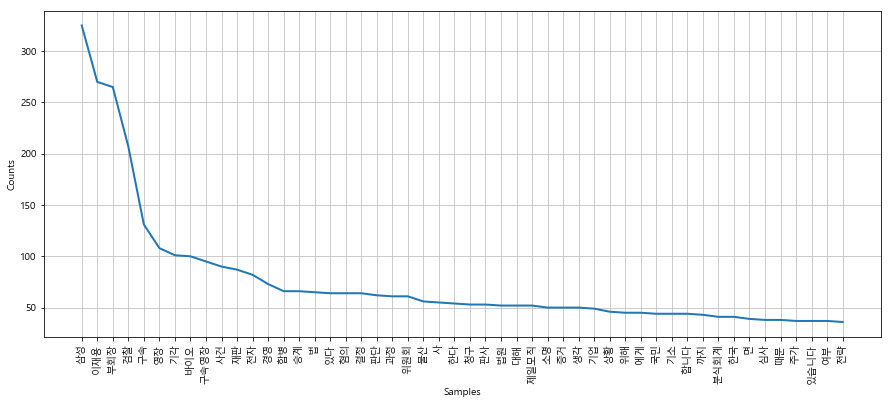

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz
plt.figure(figsize=(15,6))
ko.plot(50) 
plt.show()

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [36]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [37]:
data = ko.vocab().most_common(300)

print(len(data))
data

300


[('삼성', 325),
 ('이재용', 270),
 ('부회장', 265),
 ('검찰', 207),
 ('구속', 131),
 ('영장', 108),
 ('기각', 101),
 ('바이오', 100),
 ('구속영장', 95),
 ('사건', 90),
 ('재판', 87),
 ('전자', 82),
 ('경영', 73),
 ('합병', 66),
 ('승계', 66),
 ('법', 65),
 ('있다', 64),
 ('혐의', 64),
 ('결정', 64),
 ('판단', 62),
 ('과정', 61),
 ('위원회', 61),
 ('물산', 56),
 ('사', 55),
 ('한다', 54),
 ('청구', 53),
 ('판사', 53),
 ('법원', 52),
 ('대해', 52),
 ('제일모직', 52),
 ('소명', 50),
 ('증거', 50),
 ('생각', 50),
 ('기업', 49),
 ('상황', 46),
 ('위해', 45),
 ('에게', 45),
 ('국민', 44),
 ('기소', 44),
 ('합니다', 44),
 ('까지', 43),
 ('분식회계', 41),
 ('한국', 41),
 ('면', 39),
 ('심사', 38),
 ('때문', 38),
 ('주가', 37),
 ('있습니다', 37),
 ('여부', 37),
 ('전략', 36),
 ('문제', 36),
 ('더', 36),
 ('=', 36),
 ('직스', 35),
 ('정도', 35),
 ('사람', 35),
 ('▲', 35),
 ('이미', 34),
 ('우리', 34),
 ('원', 33),
 ('된다', 33),
 ('관련', 33),
 ('사업', 33),
 ('해야', 33),
 ('장', 32),
 ('부장', 32),
 ('진행', 32),
 ('하지', 32),
 ('만', 32),
 ('입장', 32),
 ('사회', 32),
 ('불법', 31),
 ('피의자', 31),
 ('점', 31),
 ('재벌', 31),
 ('원칙', 30),


In [38]:
# list tuple을 딕셔너리로 만들어주는 함수
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[data[i][0]] = data[i][1]
    return todict

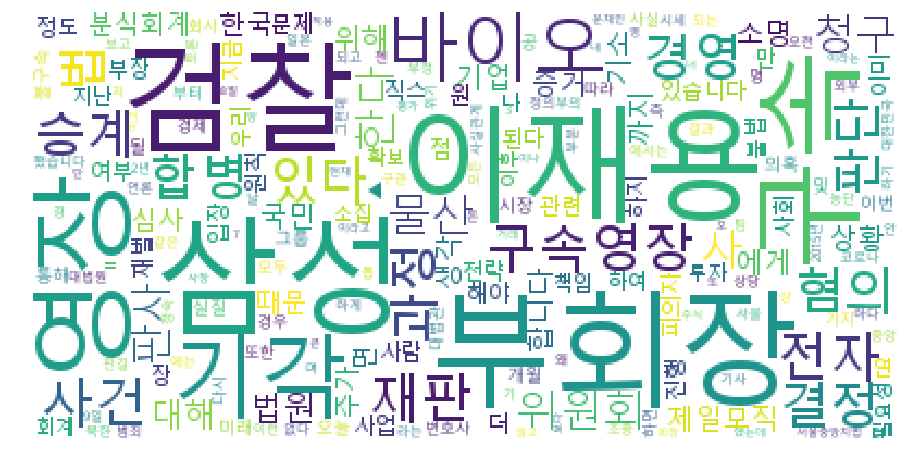

In [39]:
# 워드클라우드를 그려보자
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(todict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()